In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from CICIDS2017.analysis.features import recompute_features

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

from NIDS_attacks.fgsm import attack

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="ADV_ATT_FGSM_MLP_CICIDS2017",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-27 17:34:30,675 - INFO - Logger initialized for 'ADV_ATT_FGSM_MLP_CICIDS2017_20251127_173430'
2025-11-27 17:34:30,676 - INFO - Using device: cuda:0


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label")

dataset = full_dataset.subset(size=900*1000, multi_class=True)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-27 17:34:30,684 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-27 17:34:31,276 - INFO - Loading dataset into DataFrame
2025-11-27 17:34:44,951 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-27 17:35:00,360 - INFO - Removed 1,147 rows with non-positive 'Flow Duration'. Remaining: 1,941,546
2025-11-27 17:35:01,210 - INFO - ============================================================
2025-11-27 17:35:01,210 - INFO - Preprocessing completed successfully
2025-11-27 17:35:01,211 - INFO - Final dimensions: 1,939,551 rows x 71 columns
2025-11-27 17:35:01,211 - INFO - Total rows removed: 274,918 (12.41%)
2025-11-27 17:35:01,212 - INFO - data retention rate: 87.59%
2025-11-27 17:35:01,212 - INFO - ============================================================
2025-11-27 17:35:01,213 - INFO - Optimizing memory usage of the dataset...
2025-11-27 17:35:01,216 - INFO - Initial memory usage: 1065.43 MB
2025-11-27 17:35:01,886 - INFO 

In [3]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(
    input_size=input_size,
    layer_features=[128, 64, 32],
    layer_classifier=[16],
    num_classes=num_classes,
    device=device
)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pretrained_models/MLP{input_size}x{num_classes}.400.pt")

Input Size: 70, Num Classes: 4


2025-11-27 17:35:06,986 - INFO - Running analysis for PyTorch model: MLP - CICIDS2017 - Before Attack on device: cuda:0


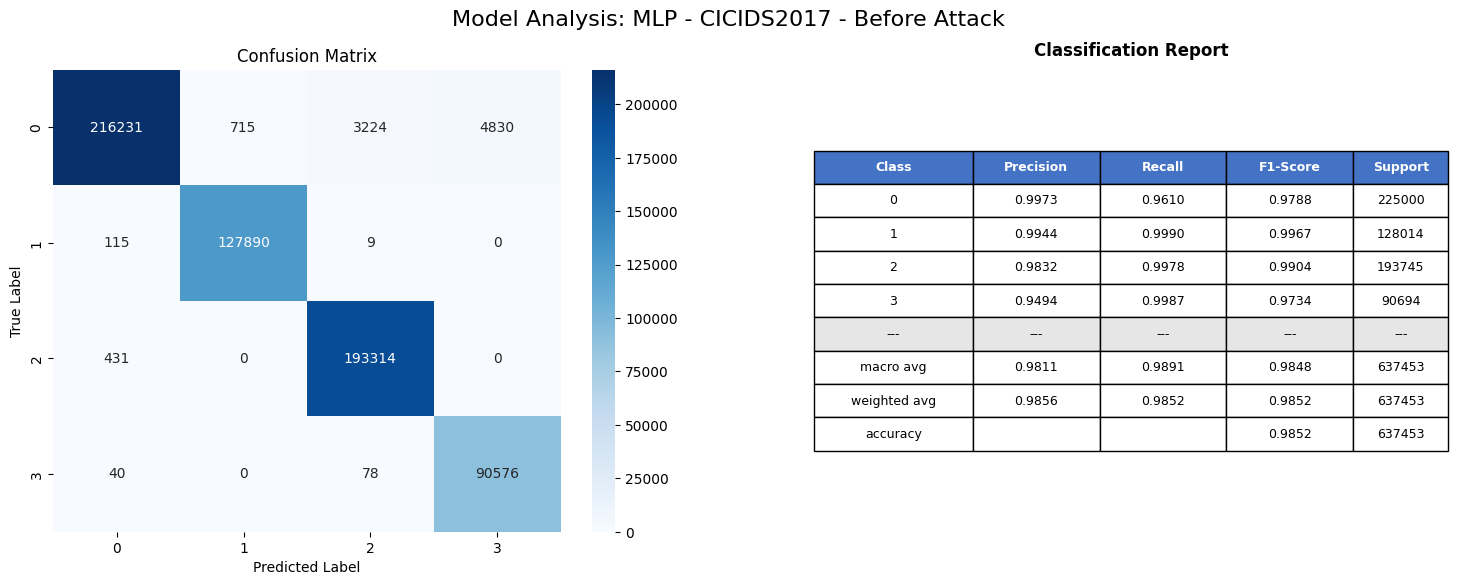

In [4]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)),
    y_test=torch.vstack((y_train, y_val)),
    num_classes=num_classes,
    logger=logger,
    root_dir=root_dir,
    title="MLP - CICIDS2017 - Before Attack",
    plot=True,
    device=device
)

In [5]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[:20]

adversarial_attack_input = dataset.features.iloc[attack_indices].iloc[random_idx].values.astype('float32')

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).to(device)

print("Original input:", adversarial_attack_input.shape)

Original input: torch.Size([20, 70])


In [6]:
x_adv = adversarial_attack_input.clone().detach().requires_grad_(True).to(device)

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

x_adv = attack(
    model=model_mlp,
    x_adv=x_adv,
    target=target,
    X_train=X_train,
    dataset=dataset,
    logger=logger,
    device=device
)

2025-11-27 17:35:19,025 - INFO - Initial prediction on adversarial input: [2 1 2 3 1 1 1 2 2 2 2 2 2 1 2 3 2 2 1 1]
2025-11-27 17:35:26,482 - INFO - Successful adversarial example found at iteration 90
2025-11-27 17:35:26,483 - INFO - Adversarial input after 90 iterations: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2025-11-27 17:35:26,484 - INFO - Magnitude of perturbation:
2025-11-27 17:35:26,485 - INFO - Mean: 7714068.0
2025-11-27 17:35:26,486 - INFO - Min: 4381.3232421875
2025-11-27 17:35:26,486 - INFO - Max: 82400008.0
2025-11-27 17:35:26,487 - INFO - Std: 17859756.0
